In [1]:
%matplotlib inline
import pandas as pd

In [2]:
# runinfo: all of the run information, by accession.
# note in particular `ScientificName`
run_info = pd.read_csv('all.runinfo.csv')
run_info.head()

,Run,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,...,Affection_Status,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash
0,DRR014176,2015-07-27 10:27:35,2015-07-27 10:32:25,30807540,3734314174,0,121,2297,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,NIID,DRA001171,NaN,public,4DA05CDDF555DF45B83261F309ADDDE7,CD8372E963A92B67C96160309CBDD52D
1,SRR8391109,2019-01-07 15:57:36,2019-01-07 15:51:59,1,1332,0,1332,0,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,CRASSPHAGE CONSORTIUM,SRA830045,NaN,public,0FCC68EB5CA35EE316539F4C0348E54F,39E03A9EF05D22741DCB6E80175743D0
2,DRR019507,2016-03-05 08:47:09,2016-03-05 08:53:45,8517086,4246043700,8517086,498,2687,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,MIYAZAKI,DRA001862,NaN,public,4580B926CA1E057CDED2089BF0BB1003,D456B6384D34959FC2706FACB199D719
3,DRR021939,2015-01-15 10:15:18,2015-01-15 10:18:19,18645,10781479,0,578,28,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,TOHOKUGL,DRA002421,NaN,public,B36925AE092F9ED96FA6EE6435522481,B904CCB0FE4FA1A287DDB5177B781F85
4,DRR025071,2016-03-09 18:20:13,2016-03-10 05:18:09,65366252,19609875600,65366252,300,10905,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,KYOTO_PREF,DRA002733,NaN,public,ED1A01B5C747C37B3641528802099C4C,C55C7EABB80C9A01ADA378250F62561A


In [3]:
# our outputs from gather
summary_df = pd.read_csv('all.summary.csv')

total_num = len(summary_df)
num_no_matches = len(summary_df[summary_df['n_matches'] == 0])
print(f"Of {total_num} datasets, {num_no_matches} have no matches.")

Of 9988 datasets, 2000 have no matches.


In [4]:
# build a df for the non-empty ones
nonempty_df = summary_df[summary_df['n_matches'] != 0]

In [5]:
nonempty_df.head()

,sample,n_matches,p_weighted_covered
0,DRR014176,373,88.1
1,DRR019507,97,4.3
2,DRR021939,1,68.0
3,DRR025071,1069,39.1
4,DRR033608,26,12.2


In [6]:
nonempty_df.describe()

,n_matches,p_weighted_covered
count,7988.000000,7988.000000
mean,273.413495,49.273748
std,455.414336,33.120600
min,1.000000,0.000000
25%,3.000000,16.100000
50%,64.000000,50.600000
75%,376.000000,81.600000
max,6215.000000,100.000000


In [7]:
# CTB note: this join may duplicate columns. FIXME.
nonempty_df2 = nonempty_df.set_index('sample').join(run_info.set_index("Run")['ScientificName'])
nonempty_df2[~nonempty_df2.ScientificName.isnull()].head()

,n_matches,p_weighted_covered,ScientificName
DRR014176,373,88.1,human metagenome
DRR019507,97,4.3,Bos taurus
DRR021939,1,68.0,uncultured bacterium
DRR025071,1069,39.1,pig gut metagenome
DRR033608,26,12.2,human oral metagenome


In [8]:
len(nonempty_df2.ScientificName.isnull())

8055

In [9]:
# our hand-coded remapping information for `ScientificName` to collate.
sra_remapping = pd.read_csv('categories/mapping.csv')
sra_remapping.head()

,Organism Name,sample_type
0,viral metagenome,viral metagenome
1,human viral metagenome,viral metagenome
2,marine metagenome,marine metagenome
3,human oral metagenome,human metagenome
4,Equus caballus,animal metagenome


In [10]:
# remap all the `ScientificName` into `sample_type`, paying attention to our hand coding.
# if not recoded, just return original value.
#
# this could be made much faster with pandas magic. FIXME!
def do_remap(val):
    new_vals = list(sra_remapping[sra_remapping['Organism Name'] == val].sample_type)
    if new_vals:
        return new_vals[0]
    return val
    
nonempty_df2['sample_type'] = nonempty_df2['ScientificName'].apply(do_remap)

In [11]:
# count the things.
nonempty_df2["sample_type"].value_counts()[:20]

human metagenome            3907
animal metagenome            524
unknown                      502
soil metagenome              396
marine metagenome            260
plant metagenome             127
freshwater metagenome        113
sediment metagenome          107
viral metagenome             100
bacterium                     68
wastewater metagenome         64
indoor metagenome             64
aquatic metagenome            49
food metagenome               42
groundwater metagenome        38
bioreactor metagenome         34
hot springs metagenome        33
human vaginal metagenome      32
milk metagenome               32
biofilm metagenome            31
Name: sample_type, dtype: int64

In [12]:
#plot_names = ['human metagenome', 'marine metagenome']
# pick the top NUM to plot
NUM=5
plot_names = list(nonempty_df2["sample_type"].value_counts()[0:NUM].index)
print(plot_names)

['human metagenome', 'animal metagenome', 'unknown', 'soil metagenome', 'marine metagenome']


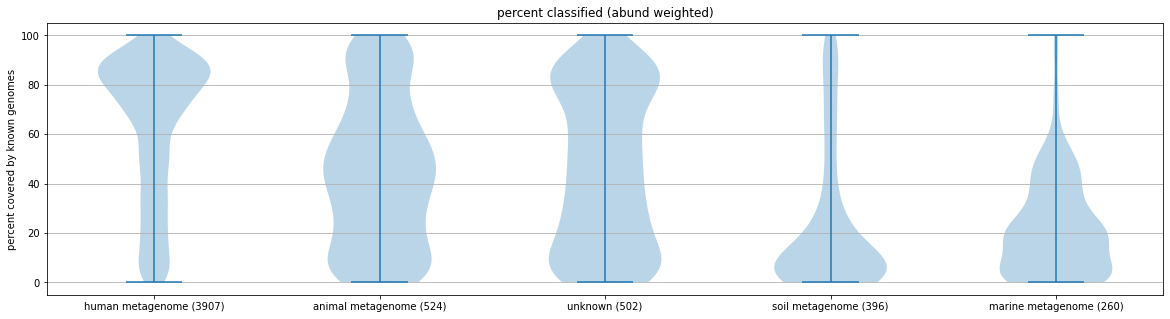

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=[20, 5])

datasets = []
for name in plot_names:
    datasets.append(nonempty_df2[nonempty_df2.sample_type == name]["p_weighted_covered"].values)

axes.violinplot(dataset = datasets)
#                           nonempty_df[df.Scenario == 'S2']["LMP"].values,

axes.set_title('percent classified (abund weighted)')
axes.yaxis.grid(True)
#axes.set_xlabel('Scenario')
#axes.set_ylabel('LMP ($/MWh)')

labels = [ f"{n} ({len(d)})" for (n, d) in zip(plot_names, datasets) ]

axes.set_xticks([y + 1 for y in range(len(plot_names))],
                labels=labels)
axes.set_ylabel('percent covered by known genomes')

#plt.show()
None

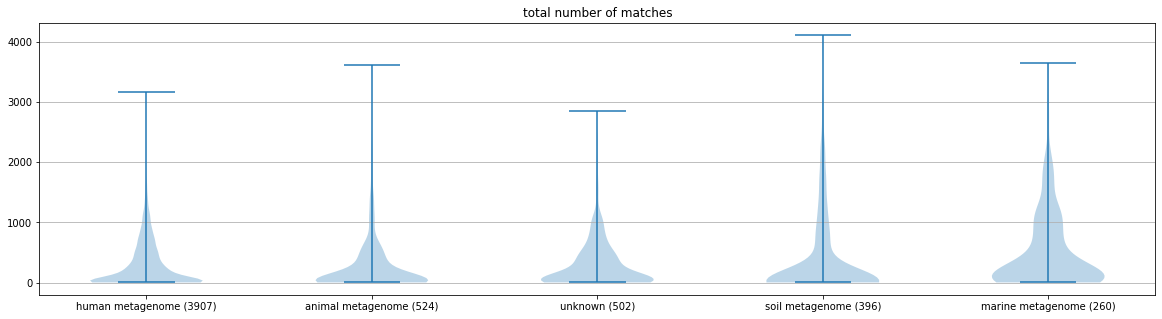

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=[20, 5])

datasets = []
for name in plot_names:
    datasets.append(nonempty_df2[nonempty_df2.sample_type == name]["n_matches"].values)

axes.violinplot(dataset = datasets)
#                           nonempty_df[df.Scenario == 'S2']["LMP"].values,

axes.set_title('total number of matches')
axes.yaxis.grid(True)
#axes.set_xlabel('Scenario')
#axes.set_ylabel('LMP ($/MWh)')

labels = [ f"{n} ({len(d)})" for (n, d) in zip(plot_names, datasets) ]

axes.set_xticks([y + 1 for y in range(len(plot_names))],
                labels=labels)
#axes.set_xlabel('Four separate samples')

#plt.show()
None